In [1]:
from graph2net.trainers import *
from graph2net.archetypes import inception,resNet,resNeXt
from graph2net.graph_generators import show_cell, gen_cell
from graph2net.data_loaders import load_data, visualize_loader
import graph2net.notifier
from graph2net.notifier import notify_me
from graph2net.petri import create_gene_pool,run_petri, mutate_pool

from IPython.core.display import display, HTML
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import logging
import time

pd.options.mode.chained_assignment = None 
logging.basicConfig(filename='logs/model_testbed.log', level=logging.INFO)

display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
def list_flatten(l):
    return [item for sublist in l for item in sublist]

data = load_data(batch_size=256)
ground_truths = np.array(list_flatten([tgt.tolist() for img,tgt in data[1]]))

In [4]:
def get_ensembling(adult_df):
    valids = adult_df[adult_df['correct']>0]
    top_n_mean=(valids['preds'].cumsum())/(np.arange(len(valids))+1)
    top_n_preds = [np.argmax(x,1) for x in top_n_mean]
    top_n_corrects = [np.sum(x==ground_truths) for x in top_n_preds]
    top_n_corrects += [0]*(len(adult_df)-len(valids))
    adult_df['top_n_corrects']=top_n_corrects
    return adult_df

In [5]:
inclusions = [{"cell":inception,"genotype":'inception'},
              {"cell":resNeXt,"genotype":'resNeXt'},
              {"cell":resNet,"genotype":'resNet'}]

creation_params = {'node_range':[6,10],
                  'connectivity_range':[.25,.75],
                  'concat':.5}

In [6]:
pool = create_gene_pool(98,inclusions=inclusions,creation_params=creation_params)

In [10]:
for generation in range(5):
    print("=== GENERATION {} ===".format(generation))
    adult_df = run_petri(pool,data=data,connectivity='linear',cell_types=[1,1],scale=2,epochs=3,verbose=False,predict=True)
    adult_df = get_ensembling(adult_df)
    display(adult_df.reset_index(drop=True))
    adult_df.to_pickle("generations/generation_{}.pkl".format(generation))
    pool = mutate_pool(adult_df, parents=25, children=50, mutation_probability=.05, new_entries=50, creation_params=creation_params)

=== GENERATION 0 ===


KeyboardInterrupt: 

In [12]:
pool = pd.read_pickle("generations/generation_3.pkl")
pool.iloc[:10]

,acc_pred,adult,cell,confidence,correct,genotype,lineage,loss,macro_pred,mutations,name,offspring,params,preds,top_n_corrects,type
836,7078,True,"[[0.0, 1.0, 8.0, 1.0, 0.0, 0.0, 13.0, 15.0, 5....",380,5783,"n: 14, c: 0.707","[Lipton Athena Clive, McLeod Raoul Hoffman, Ag...",3.5746,9948,5,Churchill Mesopotamia Hurwitz,0,22510,"[[0.975654661655426, 0.059765931218862534, 0.6...",5783,sum
0,7033,True,"[[0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 13.0, 15.0, 0....",380,5748,"n: 14, c: 0.707","[Hindi Sammy Juanita, Geminid Balkan Freetown,...",3.7149,9835,3,McCormick Minsky Antaeus,3,21910,"[[-0.10546603053808212, -2.682469606399536, 1....",6054,sum
1,6996,True,"[[0.0, 1.0, 1.0, 1.0, 14.0, 0.0, 13.0, 15.0, 5...",380,5700,"n: 14, c: 0.707","[Schmitt Homeric Miltonic, Ariadne Purdue Monr...",3.5299,9946,4,Lucifer Pluto Birmingham,4,22506,"[[-0.1727834939956665, -2.552724838256836, 2.1...",6147,sum
2,6986,True,"[[0.0, 1.0, 1.0, 1.0, 5.0, 0.0, 13.0, 15.0, 5....",380,5681,"n: 14, c: 0.707","[Latinate Duluth Rutland, Ariadne Purdue Monro...",3.7151,10030,4,McNaughton Nostrand Barnhard,0,23054,"[[-0.046615831553936005, -1.0343507528305054, ...",6183,sum
3,6970,True,"[[0.0, 5.0, 1.0, 5.0, 0.0, 0.0, 1.0, 0.0, 0.0,...",380,5566,"n: 14, c: 0.688",[Fischer Paulson Kerouac],3.6633,11045,1,Igor Franz Maryland,4,28574,"[[-0.9154147505760193, -2.4322259426116943, 0....",6262,sum
846,6964,True,"[[0.0, 1.0, 14.0, 1.0, 0.0, 0.0, 13.0, 15.0, 5...",380,5662,"n: 14, c: 0.707","[Lipton Athena Clive, McLeod Raoul Hoffman, Ag...",3.5513,9926,5,Fogarty Labrador Olsen,0,22614,"[[-1.2526894807815552, -1.125349521636963, 0.0...",6287,sum
4,6961,True,"[[0.0, 1.0, 1.0, 1.0, 5.0, 0.0, 13.0, 15.0, 5....",380,5659,"n: 14, c: 0.707","[Ariadne Purdue Monrovia, Geminid Balkan Freet...",3.4676,9913,3,Latinate Duluth Rutland,3,22414,"[[-0.959526002407074, -2.693593740463257, 0.98...",6339,sum
835,6958,True,"[[0.0, 1.0, 1.0, 1.0, 14.0, 0.0, 13.0, 15.0, 5...",380,5659,"n: 14, c: 0.707","[Lucifer Pluto Birmingham, Schmitt Homeric Mil...",3.3615,10162,5,Conrad Chrysler Penrose,0,23518,"[[-0.6423532366752625, 0.3680410087108612, 0.2...",6319,sum
821,6956,True,"[[0.0, 1.0, 1.0, 1.0, 5.0, 0.0, 13.0, 15.0, 5....",380,5689,"n: 14, c: 0.707","[Habib Saskatchewan Jupiter, Latinate Duluth R...",3.6744,9706,5,Malthusian Burma Aubrey,0,20982,"[[1.4782226085662842, -2.237123966217041, -0.3...",6354,sum
5,6953,True,"[[0.0, 1.0, 1.0, 1.0, 5.0, 0.0, 13.0, 15.0, 5....",380,5649,"n: 14, c: 0.707","[Geminid Balkan Freetown, Farmington Bernadine...",3.4550,9912,2,Interpol Chen Buddhism,2,22414,"[[-0.6330905556678772, -2.8641581535339355, 1....",6324,sum


In [37]:
lr_schedule512 = {
    'type': 'cosine',
    'lr_min': .00001,
    'lr_max': .01,
    't_0': 1,
    't_mult': 2
}

def micro_net(cell,verbose=False):
    print("\n== micro ==")
    t_start = time.time()
    model = gen_and_validate([cell],data,scale=3,cell_types=[1,1])
    if verbose:
        print(model)
    loss, correct, preds,acc_preds,confs  = full_model_run(model,
                                                  data=data,
                                                  epochs=8,
                                                  lr=.01,
                                                  momentum=.9,
                                                  weight_decay=1e-4,
                                                  lr_schedule=lr_schedule512,
                                                  drop_path=False,
                                                  log=True,
                                                  track_progress=True,
                                                  prefix="Micro",
                                                  verbose=False)
    return correct,time.time()-t_start

def macro_net(cell,verbose=False):
    print("== macro ==")
    t_start = time.time()
    model = gen_and_validate([cell],data,scale=3,cell_types=[1,0,0,1,0,0,1,0,0,1,0,0,1])
    if not model:
        return np.zeros(512),0
    else:
        try:
            loss, correct, preds,acc_preds,confs = full_model_run(model,
                                                      data=data,
                                                      epochs=512,
                                                      lr=.01,
                                                      momentum=.9,
                                                      weight_decay=1e-4,
                                                      lr_schedule=lr_schedule512,
                                                      drop_path=True,
                                                      log=True,
                                                      track_progress=True,
                                                      prefix="Macro",
                                                      verbose=verbose)
        except MemoryError as e:
            print("\n{}".format(e))
            return np.zeros(512),0
    
        return correct,time.time()-t_start

full_run_scores = []
for idx,petri_cell in pool.iloc[:10].iterrows():
    full_run_score,run_time = micro_net(petri_cell['cell'])
    full_run_scores.append(full_run_score)


== micro ==
Validating model...[SUCCESS]
Estimated Timelines:
	1 epoch   : 43.21 s
	64 epochs : 46 min, 5 s
	128 epochs: 1 hrs, 32 mins, 11 s
	512 epochs: 6 hrs, 8 mins, 44 s
Number of parameters: 59,378


KeyboardInterrupt: 

In [31]:
maxes = [(i,max(x)) for (i,x) in enumerate(full_run_scores)]
maxes.sort(key=lambda x: x[1],reverse=True)
maxes
best_cell = pool.iloc[:10].iloc[maxes[0][0]]['cell']

In [ ]:
torch.cuda.empty_cache()
macro_net(best_cell)

== macro ==
Validating model...[SUCCESS]
Estimated Timelines:
	1 epoch   : 3 min, 11 s
	64 epochs : 3 hrs, 23 mins, 53 s
	128 epochs: 6 hrs, 47 mins, 47 s
	512 epochs: 27 hrs, 11 mins, 8 s
Number of parameters: 3,347,554


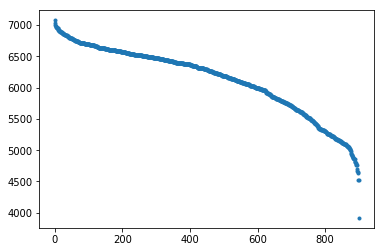

In [44]:
plt.plot(range(len(pool)),pool['acc_pred'],".")